Create plot for full ensemble of SLR projections for 3 SSPs

Ensemble contains a range of ESMs and ISMs

Computation is done with and without feedback

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import utils as ut


In [2]:
ds = xr.open_dataset('../data/dummy.nc')
ds = ds.isel(exp=slice(0,5))
ds = ds.drop_sel(esm='CAS-ESM2-0',ism=['PISM_DMI','IMAU_UU'])

In [3]:
mpl.rcParams['figure.subplot.wspace'] = .1
mpl.rcParams['figure.subplot.left'] = .1
mpl.rcParams['figure.subplot.right'] = .99
mpl.rcParams['figure.figsize'] = (7,3)

In [4]:
#ds = ds.isel(esm=[0,1],ism=[0,1])
bmp = 'lin'
niter = 1

In [5]:
slr_nf = np.zeros((len(ds.ssp),len(ds.esm)*len(ds.ism),len(ds.time)))
slr_wf = np.zeros((len(ds.ssp),len(ds.esm)*len(ds.ism),len(ds.time)))

In [6]:
for s,ss in enumerate(ds.ssp.values):
    for e,es in enumerate(ds.esm.values):
        for i,ii in enumerate(ds.ism.values):
            idx = e*len(ds.ism)+i
            TMP,IML,SLR = ut.iterate(ds,ism=ii,esm=es,ssp=ss,bmp=bmp,niter=niter)
            slr_nf[s,idx,:] = np.sum(SLR[0,:,:],axis=1)
            slr_wf[s,idx,:] = np.sum(SLR[-1,:,:],axis=1)
            print(ss,es,ii,slr_nf[s,idx,-1],slr_wf[s,idx,-1])       

126 ACCESS-CM2 CISM_NCA 0.02161069881168272 0.029282919195905414
126 ACCESS-CM2 FETI_ULB 0.030730851463925634 0.0475444852954691
126 ACCESS-CM2 GRIS_LSC 0.01197755794778326 0.014244075314806726
126 ACCESS-CM2 ISSM_UCI 0.060641620491102236 0.07557011583849416
126 ACCESS-CM2 MALI_DOE 0.03592819528903122 0.0503632529818221
126 ACCESS-CM2 PISM_PIK 0.03531787843208275 0.0472757210920861
126 ACCESS-CM2 SICO_ILTS 0.07276559295477951 0.11077087566929711
126 ACCESS-ESM1-5 CISM_NCA 0.02222383928231347 0.030321839836943965
126 ACCESS-ESM1-5 FETI_ULB 0.03259230521463466 0.0501527679064144
126 ACCESS-ESM1-5 GRIS_LSC 0.010378304483756918 0.012677109697303419
126 ACCESS-ESM1-5 ISSM_UCI 0.06351741299993316 0.07993705006542952
126 ACCESS-ESM1-5 MALI_DOE 0.03381568947427456 0.04784125051113527
126 ACCESS-ESM1-5 PISM_PIK 0.03701075485372019 0.050264762218551924
126 ACCESS-ESM1-5 SICO_ILTS 0.07124611875951593 0.10737970922932343
126 CAMS-CSM1-0 CISM_NCA 0.022764253912112745 0.03182044933321947
126 CAMS-CS

In [7]:
mpl.rcParams['figure.subplot.wspace'] = .1
mpl.rcParams['figure.subplot.left'] = .1
mpl.rcParams['figure.subplot.right'] = .99
mpl.rcParams['figure.figsize'] = (7,3)

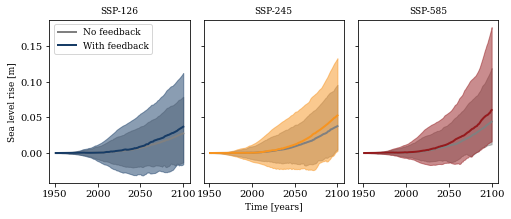

In [8]:
alpha = .5
perc = [10,90]

fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
for s,ss in enumerate(ds.ssp.values):
    dax = ax[s]
    dax.plot(ds.time,np.median(slr_nf[s,:,:],axis=0),c='.5',lw=2,label='No feedback')
    dax.fill_between(ds.time,np.percentile(slr_nf[s,:,:],perc[0],axis=0),np.percentile(slr_nf[s,:,:],perc[1],axis=0),color='.5',alpha=alpha)

    dax.plot(ds.time,np.median(slr_wf[s,:,:],axis=0),c=ut.scol[ss],lw=2,label='With feedback')    
    dax.fill_between(ds.time,np.percentile(slr_wf[s,:,:],perc[0],axis=0),np.percentile(slr_wf[s,:,:],perc[1],axis=0),color=ut.scol[ss],alpha=alpha)
    
    dax.set_title(f'SSP-{ss}')

ax[0].legend(loc='upper left')
ax[0].set_ylabel('Sea level rise [m]')
ax[1].set_xlabel('Time [years]')

plt.savefig(f'../draftfigs/full_ensemble_{bmp}_{niter}.png',dpi=450)
plt.show()